In [36]:
pip install torch pykan


In [37]:
# Libraries
import torch
import numpy as np
import pandas as pd
from kan import KAN
from kan.utils import create_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from astropy.io import fits

In [38]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [39]:
# Descargar el archivo FITS (debe ser ejecutado en la terminal)
#!wget https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spAll-v6_0_4.fits

In [40]:
# Data reading
file_path = 'SDSS_DR18.csv'
df = pd.read_csv(file_path)

print(df.head())


          objid     specobjid          ra       dec         u         g  \
0  1.240000e+18  3.240000e+17  184.950869  0.733068  18.87062  17.59612   
1  1.240000e+18  3.250000e+17  185.729201  0.679704  19.59560  19.92153   
2  1.240000e+18  3.240000e+17  185.687690  0.823480  19.26421  17.87891   
3  1.240000e+18  2.880000e+18  185.677904  0.768362  19.49739  17.96166   
4  1.240000e+18  2.880000e+18  185.814763  0.776940  18.31519  16.83033   

          r         i         z  run  ...  psfMag_g  psfMag_i  psfMag_z  \
0  17.11245  16.83899  16.70908  756  ...  19.96352  19.25145  19.05230   
1  20.34448  20.66213  20.59599  756  ...  19.92417  20.65535  20.57387   
2  17.09593  16.65159  16.35329  756  ...  19.33645  18.16669  17.78844   
3  17.41269  17.20545  17.11567  756  ...  17.96176  17.21564  17.12367   
4  16.26352  16.06320  15.97527  756  ...  16.85104  16.08275  15.98694   

    expAB_u   expAB_g   expAB_r   expAB_i   expAB_z  redshift   class  
0  0.479021  0.518483  0.5

In [41]:
# Data info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   objid        100000 non-null  float64
 1   specobjid    100000 non-null  float64
 2   ra           100000 non-null  float64
 3   dec          100000 non-null  float64
 4   u            100000 non-null  float64
 5   g            100000 non-null  float64
 6   r            100000 non-null  float64
 7   i            100000 non-null  float64
 8   z            100000 non-null  float64
 9   run          100000 non-null  int64  
 10  rerun        100000 non-null  int64  
 11  camcol       100000 non-null  int64  
 12  field        100000 non-null  int64  
 13  plate        100000 non-null  int64  
 14  mjd          100000 non-null  int64  
 15  fiberid      100000 non-null  int64  
 16  petroRad_u   100000 non-null  float64
 17  petroRad_g   100000 non-null  float64
 18  petroRad_i   100000 non-n

In [42]:
# Interest columns
selected_columns = [
    'objid',    # Main Id
    'u',        # Magnitud en la banda U
    'g',        # Magnitud en la banda G
    'r',        # Magnitud en la banda R
    'i',        # Magnitud en la banda I
    'z',        # Magnitud en la banda Z
    'redshift',
    ]

# Target dataframe
df_KAN = df[selected_columns]

#Visualization
df_KAN.head()

,objid,u,g,r,i,z,redshift
0,1.240000e+18,18.87062,17.59612,17.11245,16.83899,16.70908,0.041691
1,1.240000e+18,19.59560,19.92153,20.34448,20.66213,20.59599,-0.000814
2,1.240000e+18,19.26421,17.87891,17.09593,16.65159,16.35329,0.113069
3,1.240000e+18,19.49739,17.96166,17.41269,17.20545,17.11567,0.000087
4,1.240000e+18,18.31519,16.83033,16.26352,16.06320,15.97527,0.000018


In [43]:
# New columns: u-g , g-r, r-i, i-z
df_KAN['u-g'] = df_KAN['u'] - df_KAN['g']
df_KAN['g-r'] = df_KAN['g'] - df_KAN['r']
df_KAN['r-i'] = df_KAN['r'] - df_KAN['i']
df_KAN['i-z'] = df_KAN['i'] - df_KAN['z']

# Erasing original columns
df_KAN.drop(columns = ['u', 'g', 'r', 'i', 'z'], inplace = True)

# Visualization of new dataframe
df_KAN.head()

<ipython-input-43-3a1ed528d53a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KAN['u-g'] = df_KAN['u'] - df_KAN['g']
<ipython-input-43-3a1ed528d53a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KAN['g-r'] = df_KAN['g'] - df_KAN['r']
<ipython-input-43-3a1ed528d53a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,objid,redshift,u-g,g-r,r-i,i-z
0,1.240000e+18,0.041691,1.27450,0.48367,0.27346,0.12991
1,1.240000e+18,-0.000814,-0.32593,-0.42295,-0.31765,0.06614
2,1.240000e+18,0.113069,1.38530,0.78298,0.44434,0.29830
3,1.240000e+18,0.000087,1.53573,0.54897,0.20724,0.08978
4,1.240000e+18,0.000018,1.48486,0.56681,0.20032,0.08793


In [45]:
# Selecting interest variables and the predictor
features = ['u-g', 'g-r', 'r-i', 'i-z']
target = 'redshift'

print("Características seleccionadas:", features)
print("Variable objetivo:", target)

Características seleccionadas: ['u-g', 'g-r', 'r-i', 'i-z']
Variable objetivo: redshift


In [46]:
# Data split
X = df_KAN[features].values
y = df_KAN[target].values


In [47]:
# Train, test and validation split
X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                    y,
                                                    test_size    = 0.2,
                                                    random_state = 42
                                                    )

X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size    = 0.5,
                                                random_state = 42
                                                )


In [48]:
# Data to PyTorch tensors
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train, dtype = torch.float32, device = device)
y_train = torch.tensor(y_train, dtype = torch.float32, device = device).view(-1, 1)
X_val   = torch.tensor(X_val,   dtype = torch.float32, device = device)
y_val   = torch.tensor(y_val,   dtype = torch.float32, device = device).view(-1, 1)
X_test  = torch.tensor(X_test,  dtype = torch.float32, device = device)
y_test  = torch.tensor(y_test,  dtype = torch.float32, device = device).view(-1, 1)

In [53]:
# NaN check after the conversion
print("Valores NaN en X_train después de la conversión:")
print(torch.isnan(X_train).sum().item())
print("Valores NaN en y_train después de la conversión:")
print(torch.isnan(y_train).sum().item())

Valores NaN en X_train después de la conversión:
0
Valores NaN en y_train después de la conversión:
0


In [54]:
# Data compatible with KAN
dataset = {
    'train_input': X_train,
    'train_label': y_train,
    'val_input': X_val,
    'val_label': y_val,
    'test_input': X_test,
    'test_label': y_test,
}


In [58]:
# KAN model
model = KAN(width  = [4, 5, 1],
            grid   = 3,
            k      = 3,
            seed   = 42,
            device = device
            )

# Training the model
train_losses = []
val_losses   = []
steps        = 12

for step in range(steps):
    model.fit(dataset, opt   = "LBFGS",
                       steps = 1,
                       lamb  = 0.001
              )

    # Train and validation loss
    train_loss = mean_squared_error(y_train.cpu(), model(dataset['train_input']).detach().cpu())
    val_loss   = mean_squared_error(y_val.cpu(), model(dataset['val_input']).detach().cpu())

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Step {step+1}/{steps}: Train loss = {train_loss:.4f}, validation loss = {val_loss:.4f}")



checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.14e-01 | test_loss: 2.70e+01 | reg: 1.02e+01 | : 100%|█| 1/1 [00:00<00:00,  1.30it/s


saving model version 0.1
Paso 1/12: Pérdida de entrenamiento = 0.1717, Pérdida de validación = 0.1626


| train_loss: 3.86e-01 | test_loss: 8.62e+00 | reg: 1.08e+01 | : 100%|█| 1/1 [00:00<00:00,  1.53it/s


saving model version 0.2
Paso 2/12: Pérdida de entrenamiento = 0.1488, Pérdida de validación = 0.1403


| train_loss: 3.85e-01 | test_loss: 9.11e+00 | reg: 1.01e+01 | : 100%|█| 1/1 [00:00<00:00,  1.38it/s


saving model version 0.3
Paso 3/12: Pérdida de entrenamiento = 0.1480, Pérdida de validación = 0.1398


| train_loss: 4.44e-01 | test_loss: 1.51e+01 | reg: 1.21e+01 | : 100%|█| 1/1 [00:00<00:00,  1.37it/s


saving model version 0.4
Paso 4/12: Pérdida de entrenamiento = 0.1969, Pérdida de validación = 0.1923


| train_loss: 3.86e-01 | test_loss: 7.22e+01 | reg: 1.18e+01 | : 100%|█| 1/1 [00:00<00:00,  1.41it/s


saving model version 0.5
Paso 5/12: Pérdida de entrenamiento = 0.1487, Pérdida de validación = 0.1401


| train_loss: 5.45e-01 | test_loss: 1.80e+02 | reg: 1.29e+01 | : 100%|█| 1/1 [00:00<00:00,  1.37it/s


saving model version 0.6
Paso 6/12: Pérdida de entrenamiento = 0.2967, Pérdida de validación = 0.2299


| train_loss: 4.79e-01 | test_loss: 2.91e+02 | reg: 1.21e+01 | : 100%|█| 1/1 [00:00<00:00,  1.36it/s


saving model version 0.7
Paso 7/12: Pérdida de entrenamiento = 0.2292, Pérdida de validación = 0.1734


| train_loss: 6.91e-01 | test_loss: 1.94e+02 | reg: 1.56e+01 | : 100%|█| 1/1 [00:00<00:00,  1.42it/s


saving model version 0.8
Paso 8/12: Pérdida de entrenamiento = 0.4771, Pérdida de validación = 0.3217


| train_loss: 1.16e+00 | test_loss: 2.16e+02 | reg: 1.86e+01 | : 100%|█| 1/1 [00:00<00:00,  1.37it/s


saving model version 0.9
Paso 9/12: Pérdida de entrenamiento = 1.3377, Pérdida de validación = 0.9657


| train_loss: 6.15e+00 | test_loss: 6.98e+03 | reg: 1.87e+01 | : 100%|█| 1/1 [00:00<00:00,  1.49it/s


saving model version 0.10
Paso 10/12: Pérdida de entrenamiento = 37.8730, Pérdida de validación = 27.6062


| train_loss: 9.21e+00 | test_loss: 7.22e+03 | reg: 1.87e+01 | : 100%|█| 1/1 [00:00<00:00,  1.38it/s


saving model version 0.11
Paso 11/12: Pérdida de entrenamiento = 84.7833, Pérdida de validación = 99.3053


| train_loss: 2.71e+01 | test_loss: 7.30e+03 | reg: 3.90e+01 | : 100%|█| 1/1 [00:00<00:00,  1.32it/s

saving model version 0.12
Paso 12/12: Pérdida de entrenamiento = 736.0760, Pérdida de validación = 462.4131


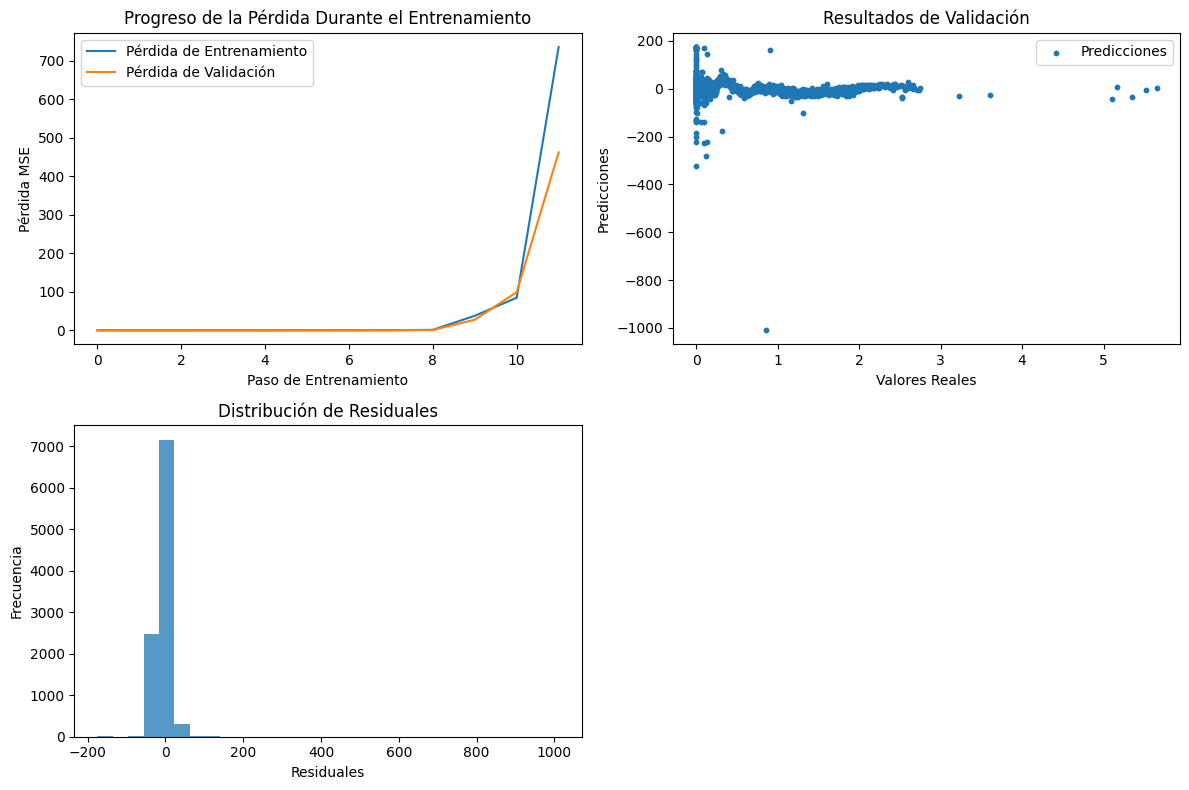

In [61]:
# Visualizing the results
plt.figure(figsize = (12, 8))

# Train loss visualization
plt.subplot(2, 2, 1)
plt.plot(train_losses, label = 'Pérdida de Entrenamiento')
plt.plot(val_losses, label   = 'Pérdida de Validación')
plt.xlabel('Paso de Entrenamiento')
plt.ylabel('Pérdida MSE')
plt.title('Progreso de la Pérdida Durante el Entrenamiento')
plt.legend()

# Predictions VS real values (in the validation set)
plt.subplot(2, 2, 2)
y_val_pred = model(dataset['val_input']).detach().cpu().numpy()
plt.scatter(y_val.cpu(), y_val_pred, s = 10, label = 'Prediccions')
plt.xlabel('Real values')
plt.ylabel('Prediccions')
plt.title('Validation results')
plt.legend()

# Residuals
plt.subplot(2, 2, 3)
residuals = y_val.cpu().numpy() - y_val_pred
plt.hist(residuals, bins = 30, alpha = 0.75)
plt.xlabel('Residuals')
plt.ylabel('Frecuency')
plt.title('Distribution')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Función Simbólica')

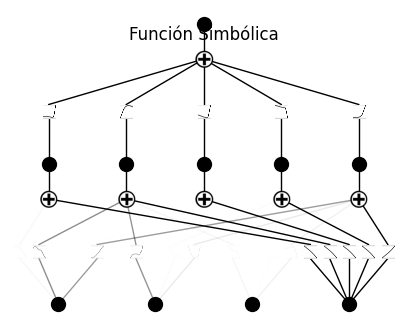

In [62]:
# Simbolic function visualization
model.plot()
plt.title('Función Simbólica')

In [63]:
# Evaluation metrics in test data
y_test_pred = model(dataset['test_input']).detach().cpu().numpy()
test_r2     = r2_score(y_test.cpu(), y_test_pred)
print(f"R^2 in test data: {test_r2:.4f}")

# Obtener la fórmula simbólica
from kan.utils import ex_round
f_symbolic = ex_round(model.symbolic_formula()[0][0], 4)
print(f"Fórmula simbólica obtenida por KAN:\n{f_symbolic}")

Coeficiente de determinación (R^2) en el conjunto de prueba: -257187322.6251
Fórmula simbólica obtenida por KAN:
0
